# 220456586_ST2195_Python_Part2

## Import Libraries

In [1]:
# Import required libraries
import os
import sqlite3
import pandas as pd
import numpy as np

# For data visualisation
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
from sklearn.model_selection import train_test_split, GridSearchCV      
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer

## Set Working Directory

In [2]:
# Check working directory, if not ammend accordingly to the same location where the database is
os.getcwd()

'C:\\Users\\Ming Wei\\Documents\\SIM\\DSBA Y2\\ST2195\\Coursework'

## Create/Store the Database (One-Time)

In [ ]:
# Create a connection to SQLite for airline1 database
conn = sqlite3.connect('airline1.db')
c = conn.cursor()

# Load in the data from the csv files and create corresponding tables in the database
airports = pd.read_csv("airports.csv")
carriers = pd.read_csv("carriers.csv")
planes = pd.read_csv("plane-data.csv")

airports.to_sql('airports', con = conn, index = False)
carriers.to_sql('carriers', con = conn, index = False)
planes.to_sql('planes', con = conn, index = False)

c.execute('''
CREATE TABLE ontime (
    Year int,
    Month int,
    DayofMonth int,
    DayOfWeek int,
    DepTime  int,
    CRSDepTime int,
    ArrTime int,
    CRSArrTime int,
    UniqueCarrier varchar(5),
    FlightNum int,
    TailNum varchar(8),
    ActualElapsedTime int,
    CRSElapsedTime int,
    AirTime int,
    ArrDelay int,
    DepDelay int,
    Origin varchar(3),
    Dest varchar(3),
    Distance int,
    TaxiIn int,
    TaxiOut int,
    Cancelled int,
    CancellationCode varchar(1),
    Diverted varchar(1),
    CarrierDelay int,
    WeatherDelay int,
    NASDelay int,
    SecurityDelay int,
    LateAircraftDelay int)
''')
conn.commit()

# Loop through years from 1999 to 2008
for i in range(1999, 2009):
    # Define file path
    file_path = f"{i}.csv"
    
    # Read CSV file with appropriate encoding and low_memory=False
    if i in [2001, 2002]:
        ontime = pd.read_csv(file_path, encoding='windows-1251', low_memory=False)
    else:
        ontime = pd.read_csv(file_path, low_memory=False)
    
    # Write data to SQLite database
    if i == 1999:
        ontime.to_sql('ontime', conn, if_exists='replace', index=False)
    else:
        ontime.to_sql('ontime', conn, if_exists='append', index=False)

# Commit changes to the database
conn.commit()

## Connect to Database

In [2]:
# Connect to 'airline1.db'
conn = sqlite3.connect('airline1.db')
c = conn.cursor()

## Question 1:
What are the best times and days of the week to minimise delays each year?

### Step 1: Exploration of Data

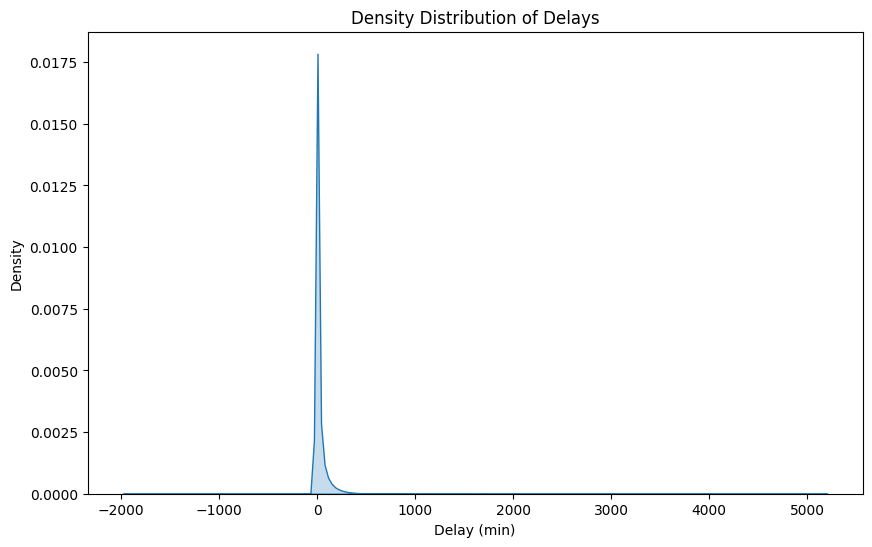

In [6]:
# Execute SQL query
c.execute('''
SELECT (ArrDelay + DepDelay) AS TotalDelay
FROM ontime
WHERE ontime.Cancelled = 0 AND ontime.Diverted = 0
''')

# Fetch data and create DataFrame
data = c.fetchall()
df = pd.DataFrame(data, columns=['TotalDelay'])

# Plot density distribution of delays
plt.figure(figsize=(10, 6))
sns.kdeplot(df['TotalDelay'], fill=True)
plt.title('Density Distribution of Delays')
plt.xlabel('Delay (min)')
plt.ylabel('Density')
plt.show()

To answer this question, we equate delays as Arrival Delay, since it directly reflects the impact of the delay on the arrival time of the flight, which is the key concern for passengers. Furthermore, using both Departure and Arrival Delays may result in double counting.

Based on the figure above, we observe that majority of the flights have little to no delay. Hence, we will focus on delays greater than zero.

### Step 2: Answering the Question

#### For best times to minimise delays in each year

In [8]:
# Data Wrangling for 'best times of the year to minimise delays'
# Execute SQL query
c.execute('''
SELECT Year, DepTime AS Hour, AVG(ArrDelay) AS AvgDelay
FROM ontime
WHERE ontime.Cancelled = 0 AND ontime.Diverted = 0 AND ontime.ArrDelay > 0
GROUP BY Year, Hour
''')

# Fetch data and create data frame
data = c.fetchall()
df = pd.DataFrame(data, columns=['Year', 'Hour', 'AvgDelay'])

# Function to convert hour to nearest hour format based on minutes
def convert_to_nearest_hour(hour_int):
    # Extract hours and minutes
    hours = hour_int // 100
    minutes = hour_int % 100
    
    # If the time is after 2400, set it to 2400
    if hours >= 24:
        hours = 24
        minutes = 0
    else:
        # Round to nearest hour based on minutes
        if minutes >= 30:
            hours += 1
    
    # If the time is exactly 2400, set it to 0000
    if hours == 24:
        hours = 0
    
    # Convert to string and pad with zeros
    formatted_hour = str(hours).zfill(2) + '00'
    
    return formatted_hour

# Convert 'Hour' column to nearest hour format
df['Hour'] = df['Hour'].apply(convert_to_nearest_hour)

# Group the data frame by Year, Week and Hour, then calculate the average of AvgDelay
grouped = df.groupby(['Year', 'Hour'])['AvgDelay'].mean().reset_index()

# Check the grouped data frame
grouped.head()

,Year,Hour,AvgDelay
0,1999,0000,70.379209
1,1999,0100,64.130390
2,1999,0200,87.187308
3,1999,0300,147.660297
4,1999,0400,298.647685


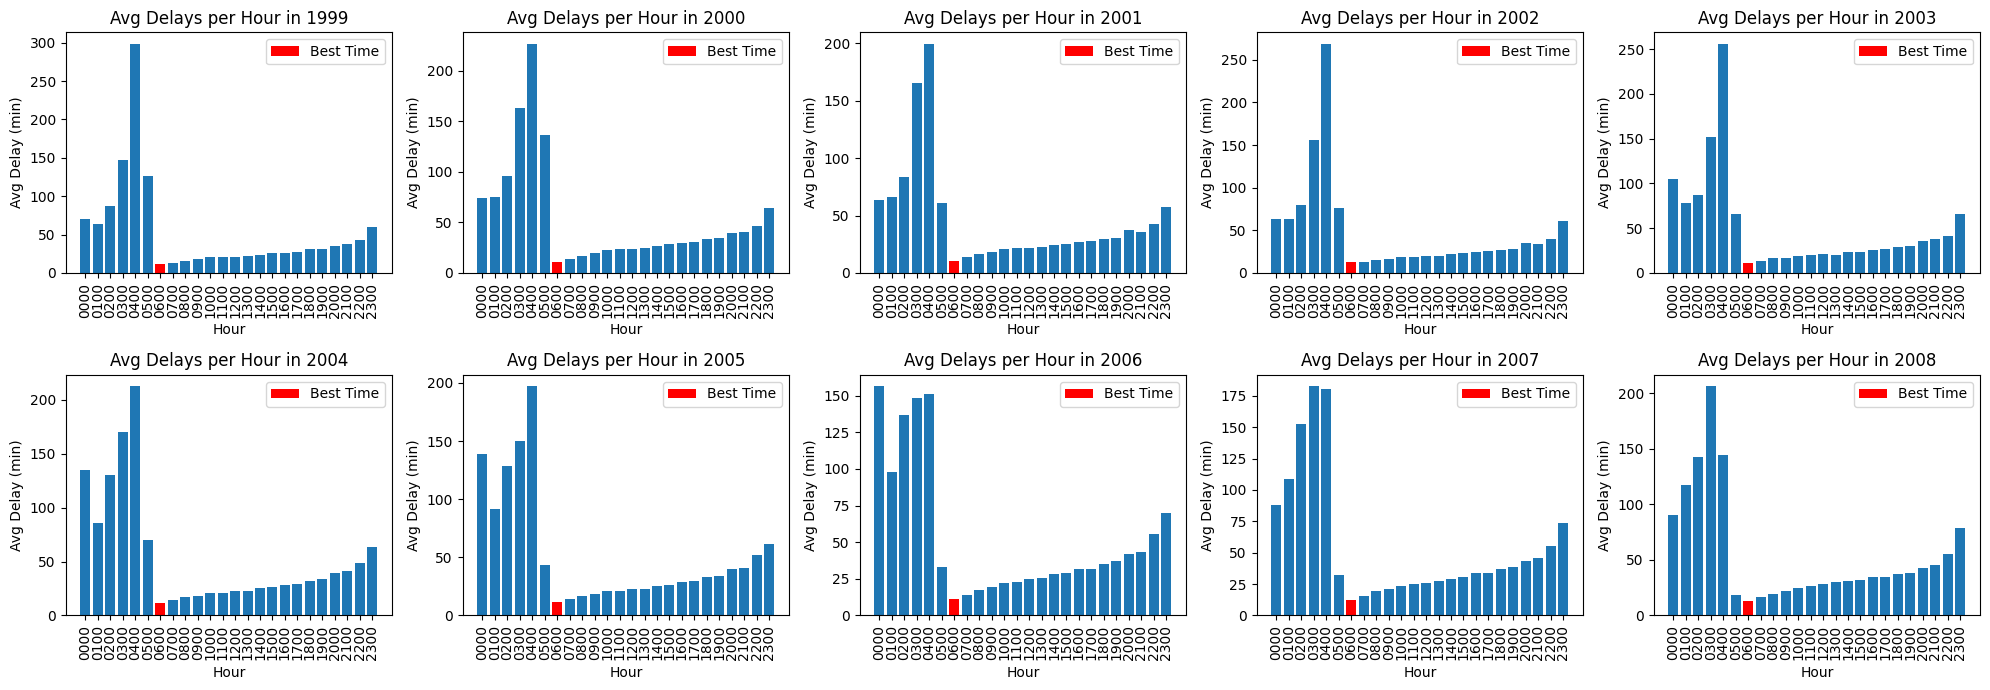

In 1999, the best time to minimise delays is 0600, with an average delay of 11 minutes.
In 2000, the best time to minimise delays is 0600, with an average delay of 11 minutes.
In 2001, the best time to minimise delays is 0600, with an average delay of 10 minutes.
In 2002, the best time to minimise delays is 0600, with an average delay of 13 minutes.
In 2003, the best time to minimise delays is 0600, with an average delay of 11 minutes.
In 2004, the best time to minimise delays is 0600, with an average delay of 11 minutes.
In 2005, the best time to minimise delays is 0600, with an average delay of 12 minutes.
In 2006, the best time to minimise delays is 0600, with an average delay of 11 minutes.
In 2007, the best time to minimise delays is 0600, with an average delay of 12 minutes.
In 2008, the best time to minimise delays is 0600, with an average delay of 13 minutes.


In [12]:
# Plot for 'best times of the year to minimise delays'
fig, ax = plt.subplots(2, 5, figsize=(20, 7))
ax = ax.flatten()
for i, year in enumerate(range(1999, 2009)):
    # Filter data for the current year
    year_data = grouped[grouped['Year'] == year]
    
    # Find the hour with the minimum average delay for the year
    best_time = year_data.loc[year_data['AvgDelay'].idxmin(), 'Hour']
    
    # Plot the average delays for each hour
    ax[i].bar(year_data['Hour'], year_data['AvgDelay'])
    
    # Highlight the best hour with a different colour
    ax[i].bar(best_time, year_data.loc[year_data['Hour'] == best_time, 'AvgDelay'], color='red', label='Best Time')
    
    ax[i].set_title(f'Avg Delays per Hour in {year}')
    ax[i].set_xlabel('Hour')
    ax[i].set_ylabel('Avg Delay (min)')
    ax[i].tick_params(axis='x', rotation=90)
    ax[i].legend()  # Show the legend

# Adjust layout and display the plot
plt.tight_layout()
plt.show()

# Print the average delay for the best time to minimise delays in each year
for year in range(1999, 2009):
    year_data = grouped[grouped['Year'] == year]
    best_time = year_data.loc[year_data['AvgDelay'].idxmin(), 'Hour']
    avg_delay = year_data.loc[year_data['Hour'] == best_time, 'AvgDelay'].values[0]
    # Round the average delay to the nearest minute
    avg_delay_rounded = round(avg_delay)
    print(f"In {year}, the best time to minimise delays is {best_time}, with an average delay of {avg_delay_rounded} minutes.")

#### For best day of the week to minimise delays in each year

In [13]:
# Data Wrangling for 'best day of the week to minimise delays'
# Execute SQL query
c.execute('''
SELECT Year, DayofWeek AS Day, AVG(ArrDelay) AS AvgDelay
FROM ontime
WHERE ontime.Cancelled = 0 AND ontime.Diverted = 0 AND ontime.ArrDelay > 0
GROUP BY Year, Day
''')

# Fetch data and create data frame
data = c.fetchall()
df = pd.DataFrame(data, columns=['Year', 'Day', 'AvgDelay'])

# Define the days of the week
days_of_week = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

# Convert numerical day values to corresponding day names
df['Day'] = df['Day'].replace({1: 'Monday', 2: 'Tuesday', 3: 'Wednesday', 4: 'Thursday', 5: 'Friday', 6: 'Saturday', 7: 'Sunday'})

# Check the data
df.head()

,Year,Day,AvgDelay
0,1999,Monday,26.044551
1,1999,Tuesday,23.962936
2,1999,Wednesday,25.076001
3,1999,Thursday,26.565088
4,1999,Friday,28.346563


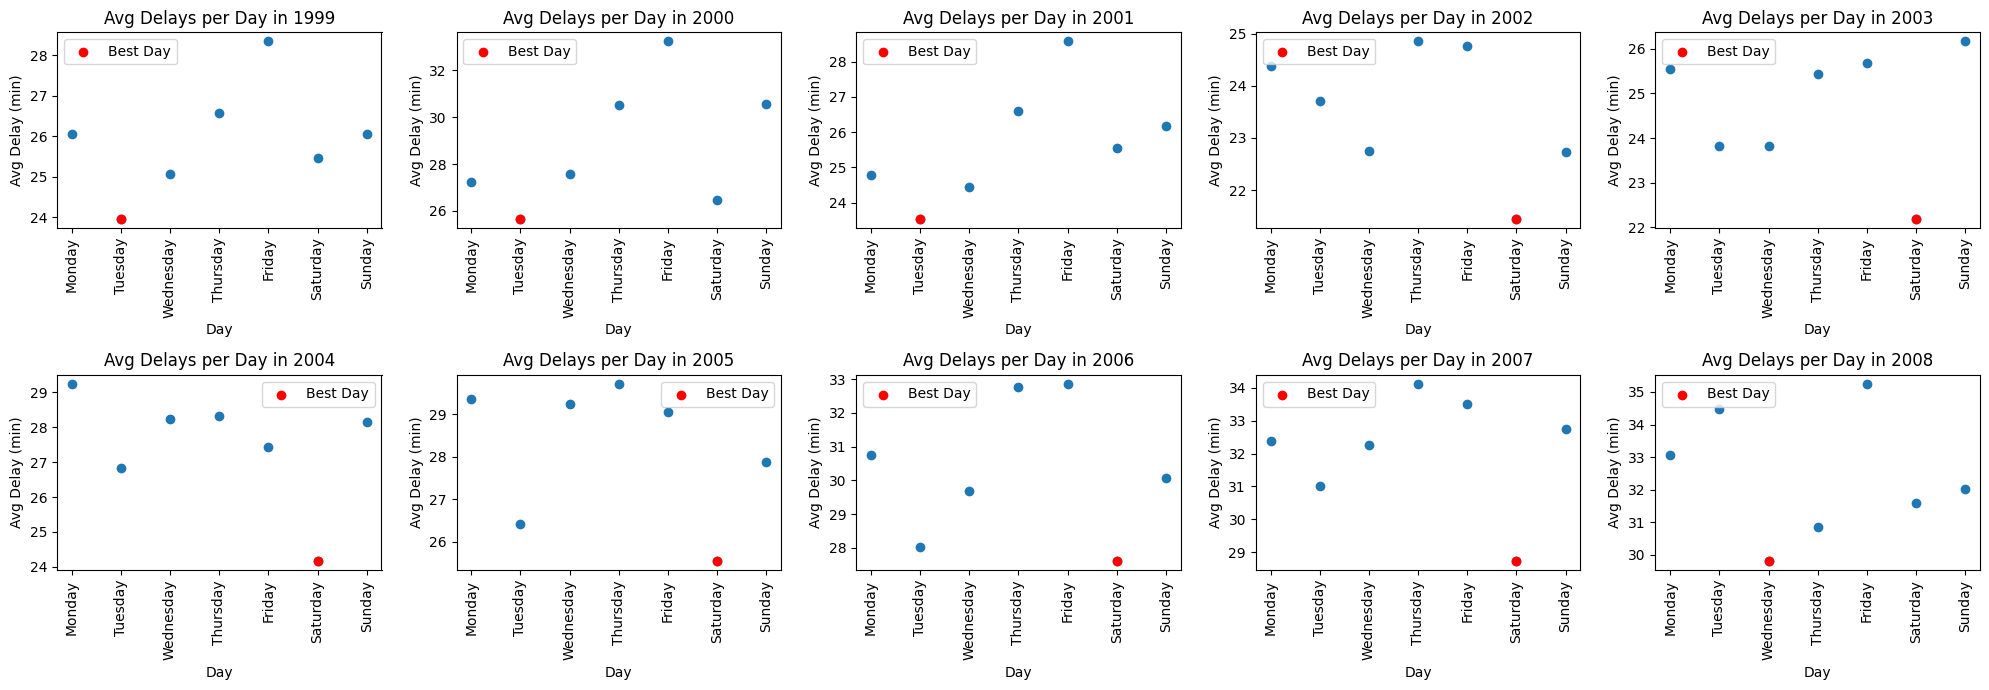

In 1999, the best day of the week to minimise delays is Tuesday, with an average delay of 24 minutes.
In 2000, the best day of the week to minimise delays is Tuesday, with an average delay of 26 minutes.
In 2001, the best day of the week to minimise delays is Tuesday, with an average delay of 24 minutes.
In 2002, the best day of the week to minimise delays is Saturday, with an average delay of 21 minutes.
In 2003, the best day of the week to minimise delays is Saturday, with an average delay of 22 minutes.
In 2004, the best day of the week to minimise delays is Saturday, with an average delay of 24 minutes.
In 2005, the best day of the week to minimise delays is Saturday, with an average delay of 26 minutes.
In 2006, the best day of the week to minimise delays is Saturday, with an average delay of 28 minutes.
In 2007, the best day of the week to minimise delays is Saturday, with an average delay of 29 minutes.
In 2008, the best day of the week to minimise delays is Wednesday, with an a

In [14]:
# Plot for 'best day of the week to minimise delays'
fig, ax = plt.subplots(2, 5, figsize=(20, 7))
ax = ax.flatten()
for i, year in enumerate(range(1999, 2009)):
    # Filter data for the current year
    year_data = df[df['Year'] == year]
    
    # Find the day with the minimum average delay for the week
    best_day = year_data.loc[year_data['AvgDelay'].idxmin(), 'Day']
    
    # Plot the average delays for each day of the week
    ax[i].scatter(year_data['Day'], year_data['AvgDelay'])
 
    # Highlight the best day of the week with a different colour
    ax[i].scatter(best_day, year_data.loc[year_data['Day'] == best_day, 'AvgDelay'], color='red', label='Best Day')
    
    ax[i].set_title(f'Avg Delays per Day in {year}')
    ax[i].set_xlabel('Day')
    ax[i].set_ylabel('Avg Delay (min)')
    ax[i].tick_params(axis='x', rotation=90)
    ax[i].legend() # Show the legend

# Adjust layout and display the plot
plt.tight_layout()
plt.show()

# Print the average delay for the best day of the week to minimise delays in each year
for year in range(1999, 2009):
    year_data = df[df['Year'] == year]
    best_day = year_data.loc[year_data['AvgDelay'].idxmin(), 'Day']
    avg_delay = year_data[year_data['Day'] == best_day]['AvgDelay'].values[0]
    # Round the average delay to the nearest minute
    avg_delay_rounded = round(avg_delay)
    print(f"In {year}, the best day of the week to minimise delays is {best_day}, with an average delay of {avg_delay_rounded} minutes.")

## Question 2:
Evaluate whether older planes suffer more delays on a year-to-year basis.

### Step 1: Data Wrangling

In [15]:
# Execute SQL query to get data from 'ontime' db and 'planes' db
c.execute('''
SELECT
    ontime.Year AS Year,
    AVG(ontime.ArrDelay) AS AvgDelay,
    planes.year AS PlaneManufactureYear
FROM
    ontime
JOIN
    planes ON ontime.TailNum = planes.tailnum
WHERE
    ontime.Cancelled = 0 AND
    ontime.Diverted = 0 AND
    ontime.ArrDelay > 0 AND
    PlaneManufactureYear IS NOT NULL AND
    PlaneManufactureYear != '0000' AND
    PlaneManufactureYear != 'None'

GROUP BY
    ontime.Year, PlaneManufactureYear
''')

# Fetch data and convert it to a list
data = c.fetchall()

# Create a new data frame with the updated data
df = pd.DataFrame(data, columns=['Year', 'AvgDelay', 'PlaneManufactureYear'])
# Filter out rows with empty or non-numeric values in 'PlaneManufactureYear' column
df = df[df['PlaneManufactureYear'].str.isnumeric()]

# View data
df.head()

,Year,AvgDelay,PlaneManufactureYear
1,1999,33.782609,1956
2,1999,28.762849,1959
3,1999,29.199387,1962
4,1999,27.072838,1963
5,1999,29.466777,1964


### Step 2: Answering the Question

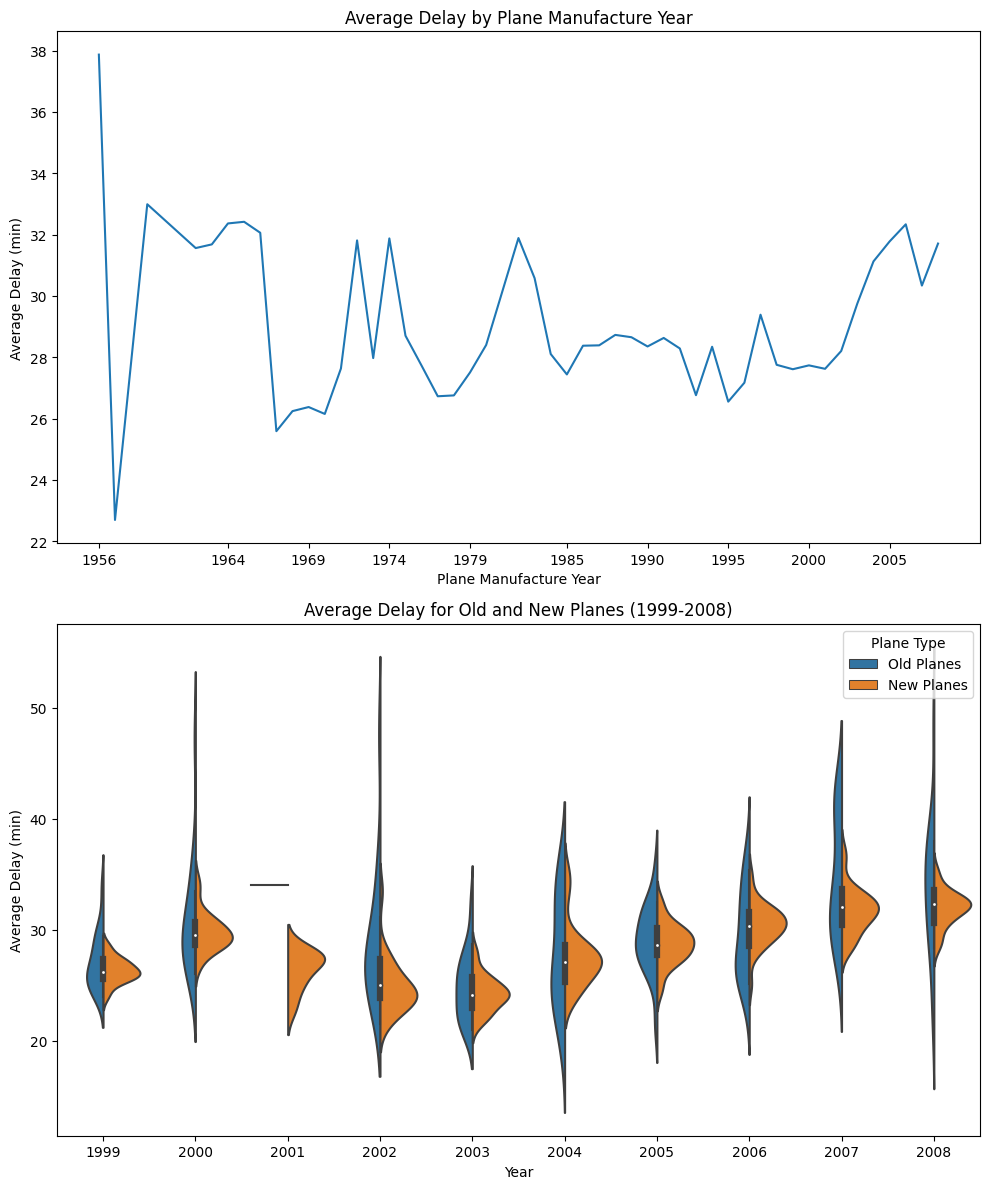

In 1999, old planes have a higher average delay.
In 2000, old planes have a higher average delay.
In 2001, old planes have a higher average delay.
In 2002, old planes have a higher average delay.
In 2003, old planes have a higher average delay.
In 2004, old planes have a higher average delay.
In 2005, old planes have a higher average delay.
In 2006, new planes have a higher average delay.
In 2007, old planes have a higher average delay.
In 2008, old planes have a higher average delay.


In [19]:
# Filter data for older and new planes
old_planes = df[df['PlaneManufactureYear'] < 1977]
new_planes = df[df['PlaneManufactureYear'] >= 1977]

# Calculate the mean delay for each plane manufacture year
mean_delay_by_year = df.groupby('PlaneManufactureYear')['AvgDelay'].mean()


# Plotting average delays over plane age and violin plot together
fig, axes = plt.subplots(2, 1, figsize=(10, 12))

# Plotting the line plot
axes[0].plot(mean_delay_by_year.index, mean_delay_by_year.values)
axes[0].set_xlabel('Plane Manufacture Year')
axes[0].set_ylabel('Average Delay (min)')
axes[0].set_title('Average Delay by Plane Manufacture Year')
axes[0].set_xticks(mean_delay_by_year.index[::5])

# Concatenate old and new planes data for plotting
combined_data = pd.concat([old_planes.assign(plane_type='Old Planes'), 
                           new_planes.assign(plane_type='New Planes')])

# Plotting violin plot
sns.violinplot(x='Year', y='AvgDelay', hue='plane_type', data=combined_data, split=True, ax=axes[1])
axes[1].set_xlabel('Year')
axes[1].set_ylabel('Average Delay (min)')
axes[1].set_title('Average Delay for Old and New Planes (1999-2008)')
axes[1].legend(title='Plane Type')

plt.tight_layout()
plt.show()

# Iterate over the years from 1999 to 2008
for year in range(1999, 2009):
    # Get the average delays for old and new planes for the current year
    avg_delay_old = old_planes[old_planes['Year'] == year]['AvgDelay'].mean()
    avg_delay_new = new_planes[new_planes['Year'] == year]['AvgDelay'].mean()
    
    # Print out which plane category has a higher average delay for the current year
    if avg_delay_old > avg_delay_new:
        print(f"In {year}, old planes have a higher average delay.")
    elif avg_delay_new > avg_delay_old:
        print(f"In {year}, new planes have a higher average delay.")
    else:
        print(f"In {year}, old and new planes have the same average delay.")

## Disonnect from Database

In [7]:
# Close database connection
conn.close()